In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "merged_air_quality_data.csv"  # Update this to your file path
df = pd.read_csv(file_path)

In [ ]:
df = df.drop(columns=['Month', 'Season', '_Sources', '_SampleCount'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61368 entries, 0 to 61367
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Timestamp      61368 non-null  object 
 1   PM2.5 (µg/m³)  61368 non-null  float64
 2   PM10 (µg/m³)   61368 non-null  float64
 3   NO2 (µg/m³)    61368 non-null  float64
 4   NH3 (µg/m³)    61368 non-null  float64
 5   SO2 (µg/m³)    61368 non-null  float64
 6   CO (mg/m³)     61368 non-null  float64
 7   Ozone (µg/m³)  61368 non-null  float64
 8   AT (°C)        58440 non-null  float64
 9   RH (%)         61368 non-null  float64
 10  WS (m/s)       61368 non-null  float64
 11  WD (deg)       61368 non-null  float64
 12  SR (W/mt2)     61368 non-null  float64
 13  BP (mmHg)      61368 non-null  float64
dtypes: float64(13), object(1)
memory usage: 6.6+ MB


In [ ]:


# Only interpolate the AT (°C) column where values are missing
# Method 1: Linear interpolation
df['AT (°C)'] = df['AT (°C)'].interpolate(method='linear')

# Fill any remaining NaN values at the beginning or end of the time series
df['AT (°C)'] = df['AT (°C)'].fillna(method='ffill').fillna(method='bfill')

# Alternative Method 2: Time-based interpolation (often better for time series)
# df['AT (°C)'] = df['AT (°C)'].interpolate(method='time')
# df['AT (°C)'] = df['AT (°C)'].fillna(method='ffill').fillna(method='bfill')

# Check if any missing values remain
missing_values = df['AT (°C)'].isna().sum()
print(f"Remaining missing values in AT (°C): {missing_values}")

Remaining missing values in AT (°C): 0


<ipython-input-10-1bf90d4ec3c9>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['AT (°C)'] = df['AT (°C)'].fillna(method='ffill').fillna(method='bfill')


In [ ]:

# Separate the Timestamp column to preserve it
timestamp_column = df["Timestamp"]

# Drop the Timestamp column for scaling
df_for_scaling = df.drop(columns=["Timestamp"])

# Apply StandardScaler to the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_for_scaling)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df_for_scaling.columns)

# Add the Timestamp column back to the scaled data
scaled_df["Timestamp"] = timestamp_column

# Display the scaled data (you can print or save it as needed)
scaled_df.head()  # Display first few rows to check the result

,PM2.5 (µg/m³),PM10 (µg/m³),NO2 (µg/m³),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),AT (°C),RH (%),WS (m/s),WD (deg),SR (W/mt2),BP (mmHg),Timestamp
0,2.412526,1.194977,-0.084665,-0.499032,-2.204319,-0.846216,-0.141221,-0.904228,0.026047,-0.477520,-1.320366,0.273603,2.027932,01-01-2018 00:00
1,2.738299,1.045199,1.972896,-0.869917,-2.067358,-0.592631,-0.139672,-1.525834,-0.079017,-0.782478,-1.366788,0.270816,2.022208,01-01-2018 01:00
2,0.754150,1.244694,1.954880,0.071448,-1.986485,-0.846216,-0.199889,-1.497619,-0.145665,-0.668119,-1.320021,0.148140,2.304413,01-01-2018 02:00
3,0.755993,0.645515,0.525261,0.028339,-0.536699,-0.078714,-0.016993,-1.474727,-0.359033,-0.839658,-0.708612,0.469477,2.304413,01-01-2018 03:00
4,1.999934,0.688968,1.009817,-0.951003,-0.470174,0.081445,-0.495115,-1.391678,-0.491172,-0.639529,-1.455667,0.949528,2.007040,01-01-2018 04:00


In [ ]:
# Import necessary libraries
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.linear_model import LinearRegression


# Assume you want to check homoscedasticity for 'CO' using other features as predictors
X = df[['PM2.5 (µg/m³)','CO (mg/m³)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'Ozone (µg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'BP (mmHg)','SR (W/mt2)']]  # Independent variables
Y = df['NO2 (µg/m³)']  # Dependent variable

# Add a constant to the independent variables matrix (for intercept term in linear regression)
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(Y, X).fit()

# Get the residuals from the model
residuals = model.resid

# Run the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X)

# Extract test results
bp_results = {
    "Test Statistic": bp_test[0],
    "p-value": bp_test[1],
    "F-statistic": bp_test[2],
    "F p-value": bp_test[3]
}

# Print the results of the Breusch-Pagan test
print("Breusch-Pagan Test Results:")
print(f"Test Statistic: {bp_results['Test Statistic']:.4f}")
print(f"p-value: {bp_results['p-value']:.4f}")
print(f"F-statistic: {bp_results['F-statistic']:.4f}")
print(f"F p-value: {bp_results['F p-value']:.4f}")


Breusch-Pagan Test Results:
Test Statistic: 5766.9379
p-value: 0.0000
F-statistic: 636.3943
F p-value: 0.0000


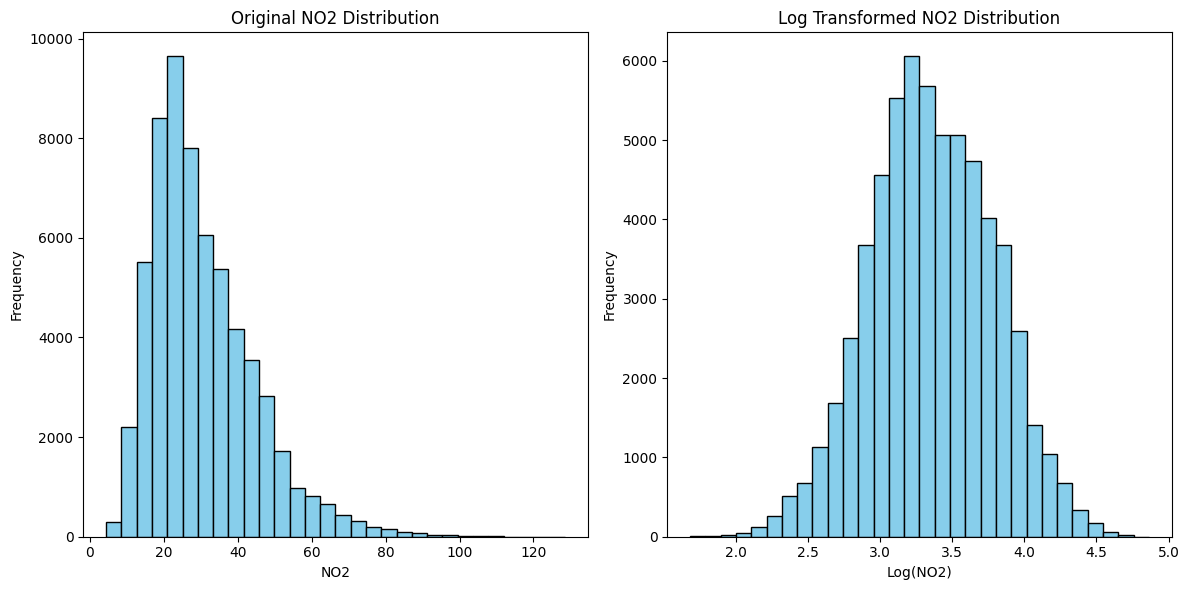

Breusch-Pagan Test Results for NO2 (Log Transformed):
Test Statistic: 674.9176
p-value: 0.0000
F-statistic: 68.2300
F p-value: 0.0000


In [ ]:
from sklearn.preprocessing import StandardScaler

# Apply log transformation to the target variable (NO2)
# Add 1 to avoid log(0) if there are zero values in the data
df['NO2_log'] = np.log(df['NO2 (µg/m³)'] + 1)

# Display the first few rows of the transformed data
df[['NO2 (µg/m³)', 'NO2_log']].head()

# Plot to visualize the effect of log transformation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['NO2 (µg/m³)'], bins=30, color='skyblue', edgecolor='black')
plt.title("Original NO2 Distribution")
plt.xlabel("NO2")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df['NO2_log'], bins=30, color='skyblue', edgecolor='black')
plt.title("Log Transformed NO2 Distribution")
plt.xlabel("Log(NO2)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# ---------- Step 1: Fit a regression model on NO2_log (as the target variable) ----------
X = df[['PM2.5 (µg/m³)','CO (mg/m³)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'Ozone (µg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'BP (mmHg)','SR (W/mt2)']]  # Independent variables
Y = df['NO2_log']  # Log-transformed NO2 as the dependent variable

# Add a constant to the independent variables matrix (for intercept term in linear regression)
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(Y, X).fit()

# Get the residuals from the model
residuals = model.resid

# Run the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X)

# Extract test results
bp_results = {
    "Test Statistic": bp_test[0],
    "p-value": bp_test[1],
    "F-statistic": bp_test[2],
    "F p-value": bp_test[3]
}

# Print the results of the Breusch-Pagan test
print("Breusch-Pagan Test Results for NO2 (Log Transformed):")
print(f"Test Statistic: {bp_results['Test Statistic']:.4f}")
print(f"p-value: {bp_results['p-value']:.4f}")
print(f"F-statistic: {bp_results['F-statistic']:.4f}")
print(f"F p-value: {bp_results['F p-value']:.4f}")


In [ ]:
# Cell 10: Export Results
# -----------------------
from google.colab import files
output_file = "Log_Transformed_data.csv"
df.to_csv(output_file, index=False)
files.download(output_file)
print(f"\nResults saved to {output_file} and downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Results saved to Log_Transformed_data.csv and downloaded!



Linear Regression Performance:
Train RMSE: 0.2714
Train R-squared: 0.6025
Test RMSE: 0.2707
Test R-squared: 0.6005

✅ No significant overfitting detected.


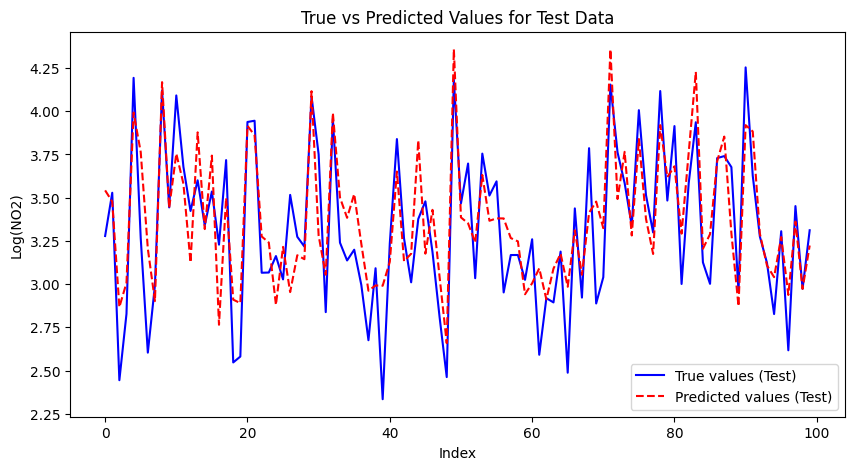

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
file_path = "Log_Transformed_data.csv"  # Update this to your file path
df = pd.read_csv(file_path)

# Use the log-transformed NO2 data as the target variable
X = df[['PM2.5 (µg/m³)', 'CO (mg/m³)', 'SO2 (µg/m³)', 'NH3 (µg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'SR (W/mt2)']]  # Independent variables
Y = df['NO2_log']  # Log-transformed NO2 as the dependent variable

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardize the independent variables (features)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# Predictions on both training and test sets
Y_train_pred = lr_model.predict(X_train)
Y_test_pred = lr_model.predict(X_test)

# Evaluate performance on training data
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
train_r2 = r2_score(Y_train, Y_train_pred)

# Evaluate performance on test data
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
test_r2 = r2_score(Y_test, Y_test_pred)

# Print results
print("\nLinear Regression Performance:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R-squared: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R-squared: {test_r2:.4f}")

# Check for Overfitting
if train_r2 > test_r2 + 0.05:
    print("\n⚠️ Possible Overfitting Detected: The model performs significantly better on training data than on test data.")
else:
    print("\n✅ No significant overfitting detected.")

# Visualizing the difference between True vs Predicted Values for the Test Set
plt.figure(figsize=(10, 5))
plt.plot(Y_test.values[:100], label="True values (Test)", color='blue')
plt.plot(Y_test_pred[:100], label="Predicted values (Test)", color='red', linestyle="dashed")
plt.title('True vs Predicted Values for Test Data')
plt.xlabel('Index')
plt.ylabel('Log(NO2)')
plt.legend()
plt.show()


Baseline Linear Regression

Linear Regression Performance:
Train RMSE: 0.2714
Train R-squared: 0.6025
Test RMSE: 0.2707
Test R-squared: 0.6005
✅ No significant overfitting detected for Linear Regression.
Feature Importance Analysis

Feature Importance:
         Feature         Score
2    NH3 (µg/m³)  24579.201014
0  PM2.5 (µg/m³)  20736.925486
1     CO (mg/m³)  15802.402432
4        AT (°C)   8506.205076
3    SO2 (µg/m³)   6329.051837
6       WS (m/s)   5433.773631
5         RH (%)   3051.726372
7     SR (W/mt2)   1293.306175
Ridge Regression with GridSearchCV
Best Ridge alpha: 10.0

Ridge Regression Performance:
Train RMSE: 0.2714
Train R-squared: 0.6025
Test RMSE: 0.2707
Test R-squared: 0.6005
✅ No significant overfitting detected for Ridge Regression.
Lasso Regression with GridSearchCV
Best Lasso alpha: 0.0001

Lasso Regression Performance:
Train RMSE: 0.2714
Train R-squared: 0.6025
Test RMSE: 0.2707
Test R-squared: 0.6005
✅ No significant overfitting detected for Lasso Regression.


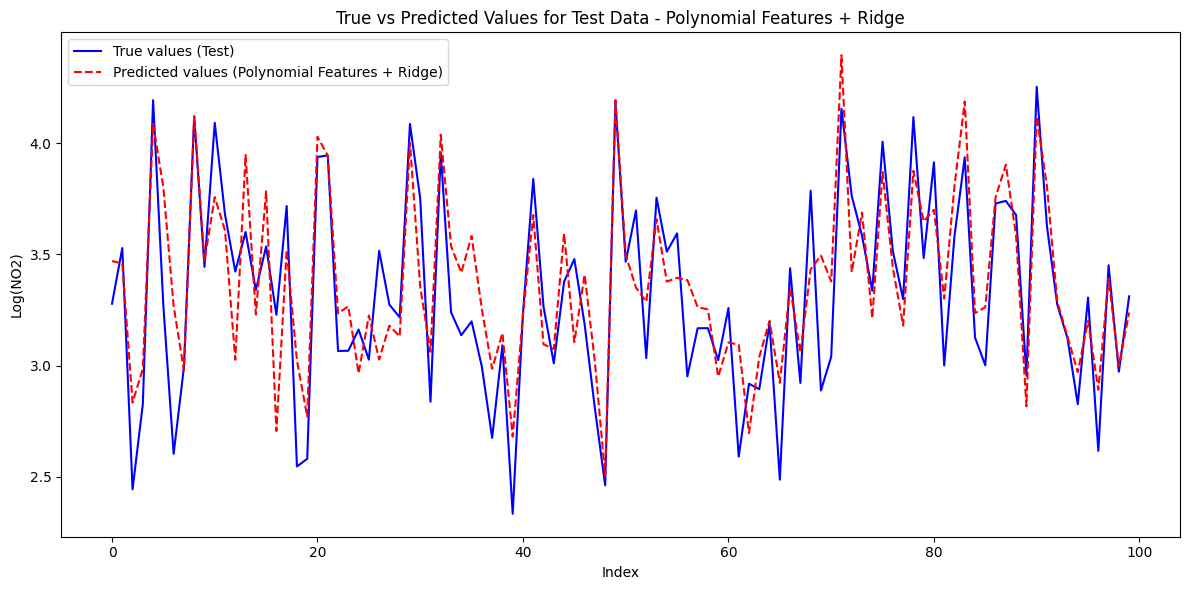

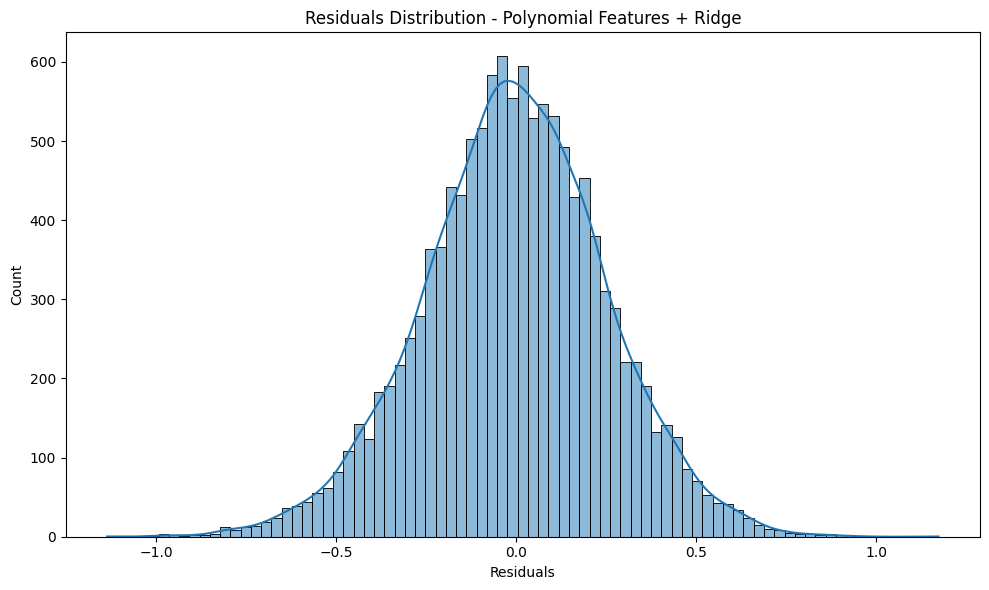

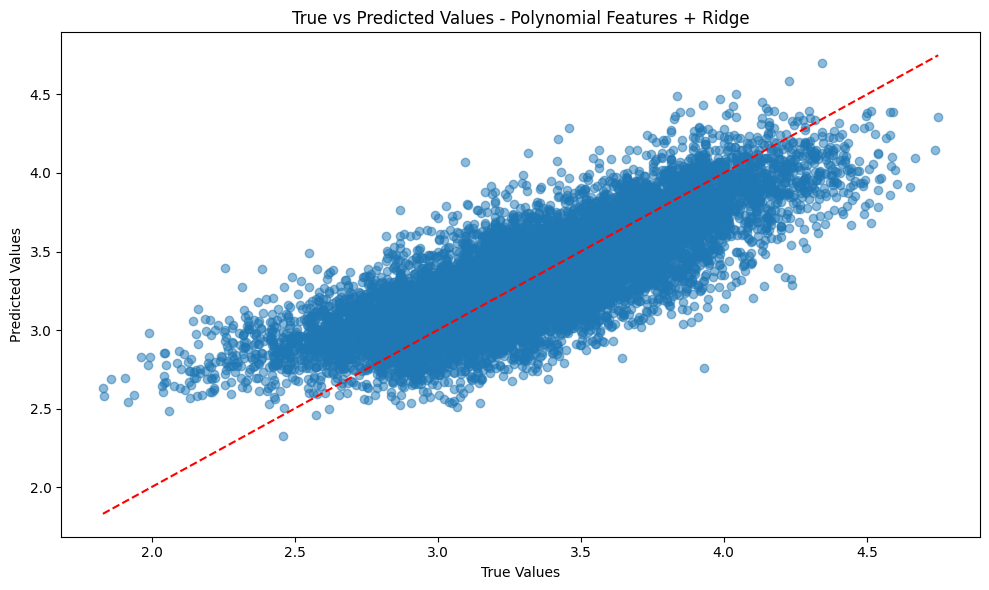

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns

# Load the dataset
file_path = "Log_Transformed_data.csv"  # Update this to your file path
df = pd.read_csv(file_path)

# Use the log-transformed NO2 data as the target variable
X = df[['PM2.5 (µg/m³)', 'CO (mg/m³)', 'NH3 (µg/m³)', 'SO2 (µg/m³)',
        'AT (°C)', 'RH (%)', 'WS (m/s)', 'SR (W/mt2)']]  # Independent variables
Y = df['NO2_log']  # Log-transformed NO2 as the dependent variable

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardize the independent variables (features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a function to evaluate and compare models
def evaluate_model(model, X_train, X_test, Y_train, Y_test, model_name="Model"):
    # Train the model
    model.fit(X_train, Y_train)

    # Predictions
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # Evaluate performance
    train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
    train_r2 = r2_score(Y_train, Y_train_pred)
    test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
    test_r2 = r2_score(Y_test, Y_test_pred)

    # Print results
    print(f"\n{model_name} Performance:")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Train R-squared: {train_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R-squared: {test_r2:.4f}")

    # Check for Overfitting
    if train_r2 > test_r2 + 0.05:
        print(f"⚠️ Possible Overfitting Detected: {model_name} performs significantly better on training data.")
    else:
        print(f"✅ No significant overfitting detected for {model_name}.")

    return model, Y_test_pred, test_r2, test_rmse

# 1. Baseline Linear Regression
print("=" * 60)
print("Baseline Linear Regression")
lr_model = LinearRegression()
lr_results = evaluate_model(lr_model, X_train_scaled, X_test_scaled, Y_train, Y_test, "Linear Regression")

# 2. Feature Importance Analysis
print("=" * 60)
print("Feature Importance Analysis")
# Select K best features
selector = SelectKBest(f_regression, k='all')
selector.fit(X_train_scaled, Y_train)
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
})
print("\nFeature Importance:")
feature_scores = feature_scores.sort_values('Score', ascending=False)
print(feature_scores)

# 3. Ridge Regression with Cross-Validation
print("=" * 60)
print("Ridge Regression with GridSearchCV")
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_scaled, Y_train)
best_ridge = ridge_grid.best_estimator_
print(f"Best Ridge alpha: {ridge_grid.best_params_['alpha']}")
ridge_results = evaluate_model(best_ridge, X_train_scaled, X_test_scaled, Y_train, Y_test, "Ridge Regression")

# 4. Lasso Regression with Cross-Validation
print("=" * 60)
print("Lasso Regression with GridSearchCV")
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}
lasso_grid = GridSearchCV(Lasso(max_iter=10000), lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train_scaled, Y_train)
best_lasso = lasso_grid.best_estimator_
print(f"Best Lasso alpha: {lasso_grid.best_params_['alpha']}")
lasso_results = evaluate_model(best_lasso, X_train_scaled, X_test_scaled, Y_train, Y_test, "Lasso Regression")

# See which features Lasso kept (non-zero coefficients)
lasso_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_lasso.coef_
})
print("\nLasso Coefficients (features with non-zero were selected):")
print(lasso_coef.sort_values('Coefficient', key=abs, ascending=False))

# 5. ElasticNet (combination of L1 and L2 regularization)
print("=" * 60)
print("ElasticNet with GridSearchCV")
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elastic_grid = GridSearchCV(ElasticNet(max_iter=10000), elastic_params, cv=5, scoring='neg_mean_squared_error')
elastic_grid.fit(X_train_scaled, Y_train)
best_elastic = elastic_grid.best_estimator_
print(f"Best ElasticNet parameters: {elastic_grid.best_params_}")
elastic_results = evaluate_model(best_elastic, X_train_scaled, X_test_scaled, Y_train, Y_test, "ElasticNet")

# 6. Polynomial Features
print("=" * 60)
print("Polynomial Features (degree=2)")
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Use Ridge to prevent overfitting with the higher dimensional polynomial features
poly_ridge = Ridge(alpha=ridge_grid.best_params_['alpha'])
poly_results = evaluate_model(poly_ridge, X_train_poly, X_test_poly, Y_train, Y_test, "Polynomial Features with Ridge")

# Compare all models
models = [
    ("Linear Regression", lr_results[2], lr_results[3]),
    ("Ridge Regression", ridge_results[2], ridge_results[3]),
    ("Lasso Regression", lasso_results[2], lasso_results[3]),
    ("ElasticNet", elastic_results[2], elastic_results[3]),
    ("Polynomial Features + Ridge", poly_results[2], poly_results[3])
]

# Sort by R-squared (higher is better)
print("=" * 60)
print("Model Comparison (sorted by R-squared):")
sorted_models = sorted(models, key=lambda x: x[1], reverse=True)
for model, r2, rmse in sorted_models:
    print(f"{model}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

# Visualize best model predictions
best_model_name = sorted_models[0][0]
best_model_idx = [m[0] for m in models].index(best_model_name)
best_model, best_preds, _, _ = [lr_results, ridge_results, lasso_results, elastic_results, poly_results][best_model_idx]

plt.figure(figsize=(12, 6))
plt.plot(Y_test.values[:100], label="True values (Test)", color='blue')
plt.plot(best_preds[:100], label=f"Predicted values ({best_model_name})", color='red', linestyle="dashed")
plt.title(f'True vs Predicted Values for Test Data - {best_model_name}')
plt.xlabel('Index')
plt.ylabel('Log(NO2)')
plt.legend()
plt.tight_layout()
plt.show()

# Visualize residuals for best model
plt.figure(figsize=(10, 6))
residuals = Y_test - best_preds
sns.histplot(residuals, kde=True)
plt.title(f'Residuals Distribution - {best_model_name}')
plt.xlabel('Residuals')
plt.tight_layout()
plt.show()

# Scatter plot of true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, best_preds, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.title(f'True vs Predicted Values - {best_model_name}')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
plt.show()